In [1]:
import tensorflow as tf

In [2]:

from __future__ import print_function
from scipy.misc import imsave
import numpy as np
import time
from keras.applications import vgg19
from keras import backend as K

from keras.preprocessing import image
from keras.models import Model
from keras.applications.vgg19 import preprocess_input

import matplotlib.pyplot as plt

%matplotlib inline

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)

#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
#K.set_session(sess)

Using TensorFlow backend.


In [3]:
content = image.load_img("chien.jpg")
content_array = image.img_to_array(content)


height = content_array.shape[0]
width = content_array.shape[1]


style = image.load_img("style.jpg", target_size=(height,width))
style_array = image.img_to_array(style)

content_array = np.expand_dims(content_array, axis=0)
content_array = preprocess_input(content_array)

style_array = np.expand_dims(style_array, axis=0)
style_array = preprocess_input(style_array)


assert content_array.shape == style_array.shape

generated = K.placeholder(shape=(1,height, width, 3))
content = K.variable(content_array)
style = K.variable(style_array)

print("Height :",height)
print("Width :", width)

Height : 467
Width : 700


In [4]:
model = vgg19.VGG19(weights='imagenet', input_tensor=K.concatenate([content,style,generated], axis=0),include_top=False)

In [5]:
def gram(tensor):
    arranged = K.permute_dimensions(tensor, (2,0,1))
    arranged = K.batch_flatten(arranged)
    return K.dot(arranged, K.transpose(arranged))

In [6]:
def style_loss(gram_style,gram_generated,shape):
    Ml = shape[1] * shape[2]
    Nl = shape[3]
    return K.sum(K.square(gram_generated - gram_style))/(4.*(Ml ** 2) * (Nl ** 2))

In [7]:
def content_loss(content,generated):
    return K.sum(K.square(generated - content))/2.

In [8]:
layers_name = [layer.name for layer in model.layers]
layers_style = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
layers_content = ["block4_conv1"]

In [9]:
dict_shape = {}
for name in layers_name:
    dict_shape[name] = model.get_layer(name).output_shape
    
print(dict_shape)

{'block1_pool': (3, 233, 350, 64), 'block2_pool': (3, 116, 175, 128), 'block5_conv4': (3, 29, 43, 512), 'input_1': (3, 467, 700, 3), 'block3_conv2': (3, 116, 175, 256), 'block2_conv2': (3, 233, 350, 128), 'block3_conv4': (3, 116, 175, 256), 'block3_pool': (3, 58, 87, 256), 'block4_pool': (3, 29, 43, 512), 'block3_conv3': (3, 116, 175, 256), 'block4_conv4': (3, 58, 87, 512), 'block4_conv3': (3, 58, 87, 512), 'block5_conv3': (3, 29, 43, 512), 'block3_conv1': (3, 116, 175, 256), 'block1_conv1': (3, 467, 700, 64), 'block5_conv2': (3, 29, 43, 512), 'block2_conv1': (3, 233, 350, 128), 'block5_pool': (3, 14, 21, 512), 'block1_conv2': (3, 467, 700, 64), 'block4_conv2': (3, 58, 87, 512), 'block4_conv1': (3, 58, 87, 512), 'block5_conv1': (3, 29, 43, 512)}


In [10]:
model_dict = dict((name,model.get_layer(name).output) for name in layers_name)

In [11]:
loss_variable = K.variable(0)
content_coeff = 0.01 #content
style_coeff = 1 #style

loss_style_variable = K.variable(0)
for name in layers_style:
    layer = model_dict[name]
    layer_generated = layer[2,:,:,:]
    layer_style = layer[1,:,:,:]
    
    gram_style = gram(layer_style)
    gram_generated = gram(layer_generated)
    
    shape = dict_shape[name]
    print(shape)
    loss_style_variable +=  (style_loss(gram_style, gram_generated,shape)/len(layers_style))

(3, 467, 700, 64)
(3, 233, 350, 128)
(3, 116, 175, 256)
(3, 58, 87, 512)
(3, 29, 43, 512)


In [12]:
loss_content_variable = K.variable(0.)
for name in layers_content:
    layer = model_dict[name]
    layer_generated = layer[2,:,:,:]
    layer_content = layer[0,:,:,:]
    loss_content_variable += (content_loss(layer_content, layer_generated)) / len(layers_content)
    

In [13]:
total_loss = content_coeff * loss_content_variable + style_coeff * loss_style_variable

In [14]:
gradients = K.gradients(total_loss, generated)[0]

#grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)


In [15]:
evaluate_loss_grads = K.function([generated], [total_loss, gradients])

In [16]:
def build_img(img_data, height, width):
    img = img_data.reshape((height, width, 3))

    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    
    
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [17]:
img_data = np.random.uniform(110,150,((1, height, width,3)))
img_data = preprocess_input(img_data)


In [18]:
iterate = K.function([generated], [gradients, total_loss])
num_epoch = 103
losses = []
import math

smooth_number = 2000.
lambdas = [0]
for i in range(num_epoch + 1):
    last_lambda = lambdas[i]
    new_lambda = (1. + math.sqrt(1. + 4.*(last_lambda**2.) ))/2.
    lambdas.append(new_lambda)
print(lambdas)

gammas = [(1. - lambdas[i])/lambdas[i+1] for i in range(len(lambdas) - 1)]

ys = [0.]
print(gammas)

[0, 1.0, 1.618033988749895, 2.193527085331054, 2.749791340120445, 3.2948796779470473, 3.83260140013, 4.365078717475032, 4.8936217645302005, 5.419098898607719, 5.942116580237085, 6.463115750438564, 6.982427415989093, 7.500306608967648, 8.016954119091308, 8.53253094283583, 9.047168203004484, 9.56097414704707, 10.074039201951413, 10.586439701027011, 11.098240681522611, 11.609498018587676, 12.120260076417877, 12.630569002318444, 13.14046175273386, 13.64997091536941, 14.159125374284798, 14.667950852706811, 15.176470359641057, 15.684704560084912, 16.192672084038094, 16.700389786088067, 17.20787296478144, 17.71513554904683, 18.222190257445686, 18.72904873487776, 19.235721670472856, 19.742218899698106, 20.248549493155114, 20.754721834099627, 21.260743686362773, 21.76662225406786, 22.27236423430589, 22.77797586374463, 23.28346295999212, 23.78883095840848, 24.29408494495499, 24.799229685582393, 25.304269652587454, 25.80920904830608, 26.31405182646003, 26.81880171143102, 27.32346221569944, 27.828

Epoch :  0
5.10403e+10


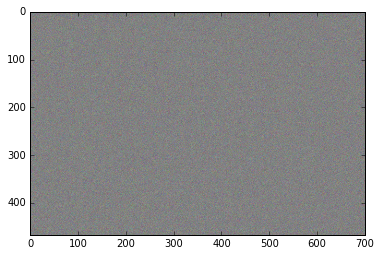

Epoch :  1
5.01405e+10
Epoch :  2
4.71684e+10
Epoch :  3
4.22294e+10
Epoch :  4
3.54037e+10
Epoch :  5
3.04074e+10
Epoch :  6
2.91971e+10
Epoch :  7
2.81327e+10
Epoch :  8
2.74649e+10
Epoch :  9
2.68651e+10
Epoch :  10
2.63916e+10
Epoch :  11
2.59904e+10
Epoch :  12
2.56679e+10
Epoch :  13
2.54113e+10
Epoch :  14
2.52085e+10
Epoch :  15
2.50436e+10
Epoch :  16
2.4914e+10
Epoch :  17
2.48112e+10
Epoch :  18
2.47266e+10
Epoch :  19
2.46602e+10
Epoch :  20
2.46115e+10


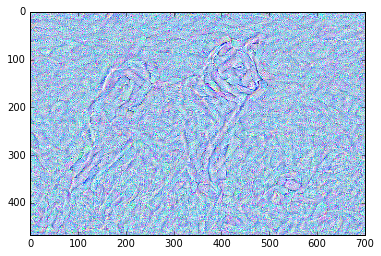

Epoch :  21
2.45796e+10
Epoch :  22
2.45589e+10
Epoch :  23
2.4547e+10
Epoch :  24
2.45455e+10
Epoch :  25
2.45487e+10
Epoch :  26
2.45592e+10
Epoch :  27
2.45792e+10
Epoch :  28
2.46083e+10
Epoch :  29
2.46416e+10
Epoch :  30
2.46811e+10
Epoch :  31
2.4725e+10
Epoch :  32
2.47751e+10
Epoch :  33
2.48262e+10
Epoch :  34
2.4878e+10
Epoch :  35
2.49294e+10
Epoch :  36
2.49859e+10
Epoch :  37
2.50451e+10
Epoch :  38
2.51054e+10
Epoch :  39
2.51701e+10
Epoch :  40
2.52388e+10


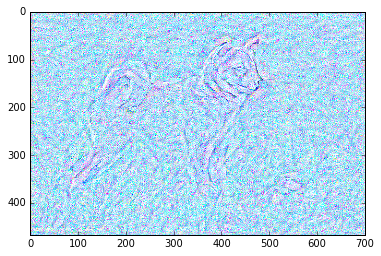

Epoch :  41
2.53068e+10
Epoch :  42
2.53814e+10
Epoch :  43
2.54645e+10
Epoch :  44
2.55697e+10
Epoch :  45
2.5691e+10
Epoch :  46
2.58691e+10
Epoch :  47
2.604e+10
Epoch :  48
2.62567e+10
Epoch :  49
2.63772e+10
Epoch :  50
2.64773e+10
Epoch :  51
2.64677e+10
Epoch :  52
2.65032e+10
Epoch :  53
2.65102e+10
Epoch :  54
2.65791e+10
Epoch :  55
2.66386e+10
Epoch :  56
2.67668e+10
Epoch :  57
2.68652e+10
Epoch :  58
2.70292e+10
Epoch :  59
2.71468e+10
Epoch :  60
2.73091e+10


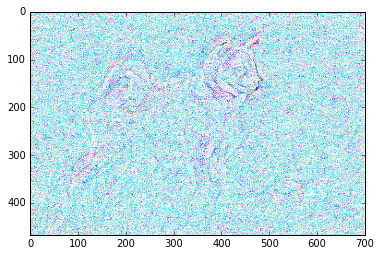

Epoch :  61
2.73977e+10
Epoch :  62
2.75128e+10
Epoch :  63
2.75732e+10
Epoch :  64
2.76507e+10
Epoch :  65
2.77237e+10
Epoch :  66
2.78214e+10
Epoch :  67
2.78983e+10
Epoch :  68
2.80028e+10
Epoch :  69
2.81005e+10
Epoch :  70
2.82143e+10
Epoch :  71
2.83178e+10
Epoch :  72
2.84128e+10
Epoch :  73
2.85587e+10
Epoch :  74
2.86522e+10
Epoch :  75
2.88498e+10
Epoch :  76
2.88805e+10
Epoch :  77
2.90536e+10
Epoch :  78
2.90227e+10
Epoch :  79
2.91963e+10
Epoch :  80
2.91045e+10


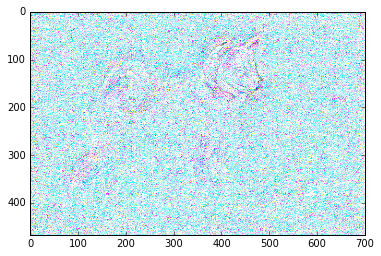

Epoch :  81
2.92947e+10
Epoch :  82
2.92016e+10
Epoch :  83
2.9413e+10
Epoch :  84
2.94225e+10
Epoch :  85
2.9848e+10
Epoch :  86
3.00342e+10
Epoch :  87
3.04687e+10
Epoch :  88
3.06179e+10
Epoch :  89
3.05587e+10
Epoch :  90
3.04315e+10
Epoch :  91
3.0219e+10
Epoch :  92
3.03352e+10
Epoch :  93
3.04165e+10
Epoch :  94
3.10547e+10
Epoch :  95
3.0772e+10
Epoch :  96
3.09886e+10
Epoch :  97
3.05237e+10
Epoch :  98
3.06793e+10
Epoch :  99
3.04346e+10
Epoch :  100
3.07818e+10


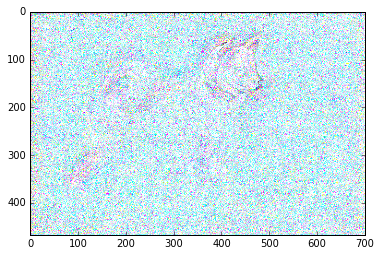

Epoch :  101
3.08189e+10
Epoch :  102
3.12322e+10


In [19]:


for it in range(num_epoch):
    print("Epoch : " , it)
    
    grads_values, loss_values = iterate([img_data])
    print(loss_values)
    
    losses.append(loss_values)
    
    
    ys_1 = img_data - (1. / smooth_number) * grads_values
    ys.append(ys_1)
    current_ys = ys[it]
    
    
    img_data = (1 - gammas[it + 1]) * ys_1 + gammas[it] * ys[it]
    
    if it % 20 == 0:
        img_toshow = build_img(np.copy(img_data),height=height,width=width)
        plt.figure()
        plt.imshow(img_toshow)
        plt.show()



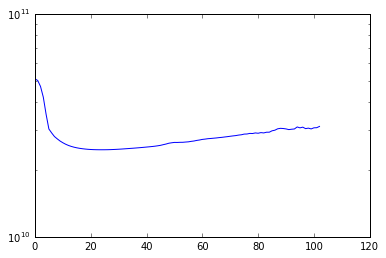

In [25]:
plt.figure()
ax = plt.gca()
ax.set_yscale('log')
plt.plot(losses)

In [27]:
def evaluate_loss_grads_from_flatten(flatten_input):   
    correct_input = flatten_input.reshape((1, height, width, 3))
    loss, grads= evaluate_loss_grads([correct_input])
    return loss, grads.flatten().astype('float64')


def getLoss(state):
    def getLoss_input(flatten_input):
        loss_values, grads_values = evaluate_loss_grads_from_flatten(flatten_input)
        state["loss"] = loss_values
        state["gradients"] = grads_values.flatten()
        #print("New state : ",state)
        return loss_values
    return getLoss_input

def getGrads(state):
    def getGrads_input(flatten_input):

        grads = state["gradients"]
        return grads.copy()
    
    return getGrads_input


'''
class State(object):

    def __init__(self):
        self.loss_values = None
        self.grads_values = None
    
    #Compute loss first
    def compute_loss(self, flatten_input):
        loss_values, grads_values = evaluate_loss_grads_from_flatten(flatten_input)
        self.loss_values = loss_values
        self.grads_values = grads_values
        return self.loss_values
    
    #Return grads
    def compute_grads(self, x):
        grads_values = self.grads_values
        return grads_values
'''


'\nclass State(object):\n\n    def __init__(self):\n        self.loss_values = None\n        self.grads_values = None\n    \n    #Compute loss first\n    def compute_loss(self, flatten_input):\n        loss_values, grads_values = evaluate_loss_grads_from_flatten(flatten_input)\n        self.loss_values = loss_values\n        self.grads_values = grads_values\n        return self.loss_values\n    \n    #Return grads\n    def compute_grads(self, x):\n        grads_values = self.grads_values\n        return grads_values\n'

it :  0
{'grad': array([ -348.56951904,   607.3034668 , -1261.55163574, ...,   -24.22306061,
          97.11361694,    94.5365448 ]), 'funcalls': 10, 'warnflag': 1, 'task': b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT', 'nit': 2}
Final picture : 


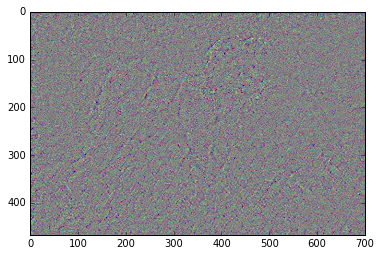

it :  1
{'grad': array([  69.57711792, -313.60778809,   44.89716339, ...,  -25.77357674,
         51.3264389 ,   49.78032684]), 'funcalls': 9, 'warnflag': 1, 'task': b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT', 'nit': 2}
Final picture : 


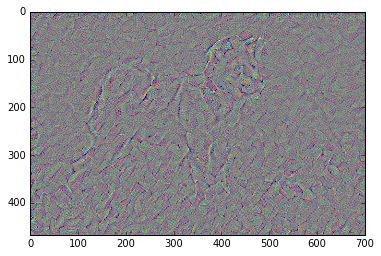

it :  2
{'grad': array([ -99.46972656,   -8.89562225, -265.82897949, ...,  -22.42750931,
         61.27644348,   57.42134094]), 'funcalls': 8, 'warnflag': 1, 'task': b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT', 'nit': 2}
Final picture : 


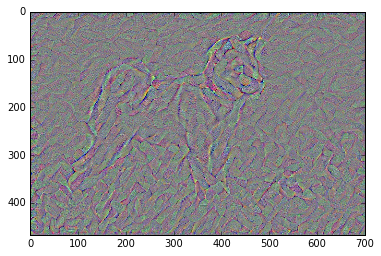

it :  3
{'grad': array([  15.16511917, -201.14880371,   28.05784607, ...,  -15.49592018,
         25.69533348,   19.75171089]), 'funcalls': 8, 'warnflag': 1, 'task': b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT', 'nit': 2}
Final picture : 


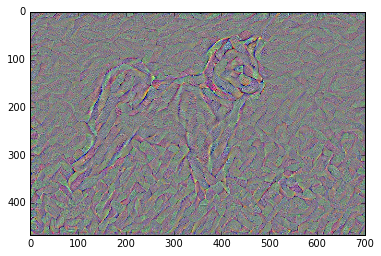

it :  4
{'grad': array([-106.0307312 , -204.29058838, -150.6804657 , ...,  -11.97134972,
         48.91270447,   42.51275635]), 'funcalls': 8, 'warnflag': 1, 'task': b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT', 'nit': 2}
Final picture : 


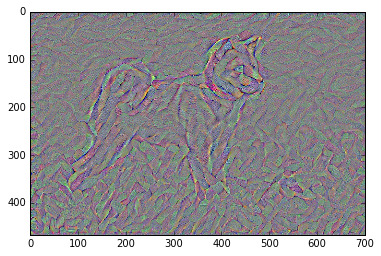

it :  5
{'grad': array([ -69.27822113, -186.22393799,  -64.61752319, ...,  -15.94327641,
         38.00963593,   30.75665283]), 'funcalls': 7, 'warnflag': 1, 'task': b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT', 'nit': 2}
Final picture : 


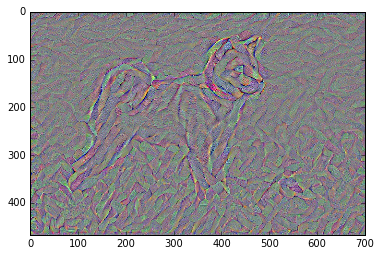

it :  6
{'grad': array([ -59.31651688, -166.32392883,  -51.54323196, ...,  -13.48279285,
         32.52330017,   27.55721283]), 'funcalls': 7, 'warnflag': 1, 'task': b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT', 'nit': 2}
Final picture : 


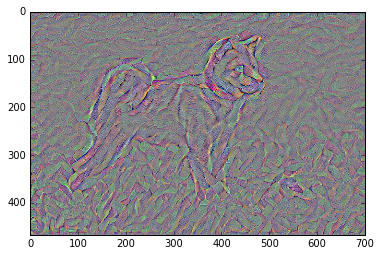

it :  7
{'grad': array([   1.07570112, -114.44113159,   29.14687729, ...,  -17.98958397,
         26.34943962,   20.2374115 ]), 'funcalls': 7, 'warnflag': 1, 'task': b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT', 'nit': 2}
Final picture : 


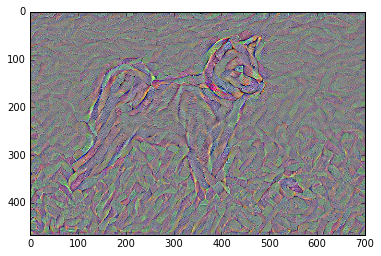

it :  8
{'grad': array([ -49.14527893, -135.68963623,  -37.18318176, ...,  -11.84896088,
         35.88434982,   27.8564682 ]), 'funcalls': 7, 'warnflag': 1, 'task': b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT', 'nit': 2}
Final picture : 


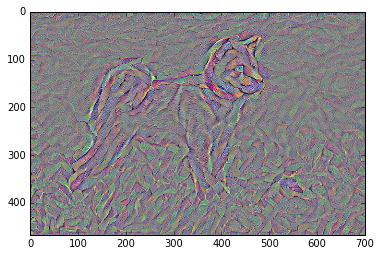

it :  9
{'grad': array([ -9.59510612, -87.0291214 ,   3.68289852, ..., -14.38326645,
        23.92886162,  17.58508682]), 'funcalls': 7, 'warnflag': 1, 'task': b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT', 'nit': 2}
Final picture : 


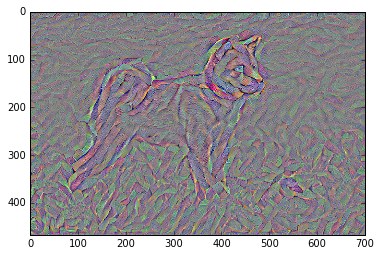

In [30]:
from scipy.optimize import fmin_l_bfgs_b


state = {}

img_data = np.random.uniform(110,150,((1, height, width,3)))
img_data = preprocess_input(img_data)


def display(xk):
    print("Current best image :")
    copy = xk.copy()
    copy = copy.reshape((1, height, width, 3))
    img_toshow = build_img(copy,height=height,width=width)
    plt.figure()
    plt.imshow(copy)
    plt.show()

loss_lbfgs = []
for it in range(10):
    min_input, min_val, info = fmin_l_bfgs_b(getLoss(state), img_data.flatten(),fprime=getGrads(state), maxiter=1, maxfun=10)
    
    loss_lbfgs.append(min_val)
    print("it : ", it)
    print(info)
    print("Final picture : ")
    img_data = min_input.reshape((1, height, width, 3))
    best_img = img_data.copy()
    best_img = best_img.reshape((1, height, width, 3))
    img_toshow = build_img(best_img,height=height,width=width)
    plt.figure()
    plt.imshow(img_toshow)
    plt.show()

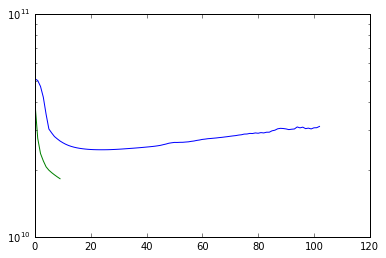

In [31]:
plt.figure()
ax = plt.gca()
ax.set_yscale('log')
plt.plot(losses)
plt.plot(loss_lbfgs)

In [ ]:
from scipy.misc import imsave

In [ ]:
imsave("chien_monet.jpg",img_toshow)